# Example for fitting Experimental Spectra using MATS
This example fits experimental Oxygen A-Band Spectra.  The provided code loads appropriate packages, defines the spectra and Dataset, generated parameter and baseline linelists, and fits the data.  This example also highlights the weighting options currently available in MATS.  

## Load Relevant Packages

In [2]:
import numpy as np
import pandas as pd
import os, sys
import matplotlib.pyplot as plt
from matplotlib import gridspec
%matplotlib inline
import MATS

import seaborn as sns
sns.set_style("whitegrid")
sns.set_style("ticks")
sns.set_context("poster")


HAPI version: 1.1.1.0
To get the most up-to-date version please check http://hitran.org/hapi
ATTENTION: Python versions of partition sums from TIPS-2017 are now available in HAPI code

           It is free to use HAPI. If you use HAPI in your research or software development,
           please cite it using the following reference:
           R.V. Kochanov, I.E. Gordon, L.S. Rothman, P. Wcislo, C. Hill, J.S. Wilzewski,
           HITRAN Application Programming Interface (HAPI): A comprehensive approach
           to working with spectroscopic data, J. Quant. Spectrosc. Radiat. Transfer 177, 15-30 (2016)
           DOI: 10.1016/j.jqsrt.2016.03.005


## Define Spectrum Instances

For experimental spectra, spectra are loaded from files by instantiating instances of the spectrum class. 

Before generating MATS.Spectrum objects from your experimental data, it is helpful to set some variables for terms that will be used in all of the MATS.Spectrum objects or throughout the fitting. In this example the minimum intensity threshold for simulation (IntensityThreshold), the minimum line intensity of lines fit in the analysis (Fit_Intensity), the order of the polynomial used in the baseline fits, and the names of columns used for the absorption, frequency, pressure, temperature, and statistics column data are defined at the top of the example.  The minimum intensity threshold for simulation will only simulate lines with an intensity above this threshold, where the minimum fit intensity defines the line intensity threshold necessary to allow parameters for that line to be varied in the fits.  

4 instances of the MATS.Spectrum class are instantiated from 4 experimental spectra. In the class instantiation, the mole fraction of the oxygen sample used is defined, the etalon amplitude and period are defined, the polynomial order of the baseline is defined, the sample is confirmed to be at natural abundance, the diluent is set to air, and the columns defined for pressure, temperature, frequency, and absorbance data are set.

The MATS.Spectrum.plot_wave_alpha() function can be called to plot any of the spectra.


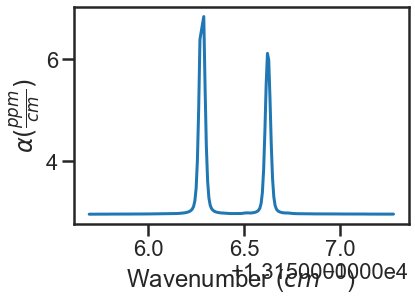

In [3]:
#Generic Fit Parameters
wave_range = 1.5 #range outside of experimental x-range to simulate
IntensityThreshold = 1e-30 #intensities must be above this value to be simulated
Fit_Intensity = 1e-24 #intensities must be above this value for the line to be fit
order_baseline_fit = 1
tau_column = 'Corrected Tau (us)' # Mean tau/us
freq_column = 'Total Frequency (Detuning)' # Total Frequency /MHz
pressure_column = 'Cavity Pressure /Torr'
temperature_column = 'Cavity Temperature Side 2 /C'
tau_stats_column = 'tau rel. std. dev./%'


#Define all Spectra individually
spec_1 = MATS.Spectrum('190510_2per_43_forfit', 
                        molefraction = { 7 :0.01949}, natural_abundance = True, diluent = 'air', 
                        etalons = {1:[0.001364, 1.271443]}, baseline_order = 1, 
                        input_freq = True, frequency_column = freq_column,
                        input_tau = True, tau_column = tau_column, tau_stats_column = tau_stats_column, 
                        pressure_column = pressure_column, temperature_column = temperature_column, 
                        nominal_temperature = 296, x_shift = 0.00)
spec_2 = MATS.Spectrum('190510_2per_55_forfit', 
                        molefraction = { 7 : 0.01949}, natural_abundance = True, diluent = 'air', 
                        etalons = {1:[0.001364, 1.271443]}, baseline_order = 1, 
                        input_freq = True, frequency_column = freq_column,
                        input_tau = True, tau_column = tau_column, tau_stats_column = tau_stats_column, 
                        pressure_column = pressure_column, temperature_column = temperature_column, 
                        nominal_temperature = 296, x_shift = 0.00)
spec_3 = MATS.Spectrum('190513_2per_82_forfit', 
                        molefraction = { 7 :0.01949}, natural_abundance = True, diluent = 'air', 
                        etalons = {1:[0.001364, 1.271443]}, baseline_order = 1, 
                        input_freq = True, frequency_column = freq_column,
                        input_tau = True, tau_column = tau_column, tau_stats_column = tau_stats_column, 
                        pressure_column = pressure_column, temperature_column = temperature_column, 
                        nominal_temperature = 296, x_shift = 0.00)
spec_4 = MATS.Spectrum('190514_2per_126_forfit', 
                        molefraction = { 7 :0.01949}, natural_abundance = True, diluent = 'air', 
                        etalons = {1:[0.001364, 1.271443]}, baseline_order = 1, 
                        input_freq = True, frequency_column = freq_column,
                        input_tau = True, tau_column = tau_column, tau_stats_column = tau_stats_column, 
                        pressure_column = pressure_column, temperature_column = temperature_column, 
                        nominal_temperature = 296, x_shift = 0.00)



spec_1.plot_wave_alpha()



## Generate a Dataset

An initial line shape parameter line list needs to be provided.  This is stored as a dataframe after reading in from a .csv file. The LoadLineListData class can be used to import line lists that are within the Linelist folder in MATS, example line lists are provided.  However, a line list can also be read in from any .csv file of the appropriate format by using the pandas read_csv(filename) function.

The next step is to combine all desired MATS Spectrum objects into a MATS Dataset object, where we give the dataset a name and define the line shape parameter line list to use.  This allows for initial consistency checks between the experimental spectra and the initial line lists.  

The MATS Dataset class contains a function to generate a baseline line list, analogous to the one for the parameter line list done outside of this example, based on the order of the baseline fit, etalons, molecules, x-shift parameters, and segments as defined by both the spectrum and dataset objects.

In [4]:
from MATS.linelistdata import linelistdata

In [5]:
#Read in linelists
PARAM_LINELIST = linelistdata['O2_ABand_Drouin_2017_linelist']
#Add all spectrum to a Dataset object
SPECTRA = MATS.Dataset([spec_1, spec_2, spec_3, spec_4], 'Line Intensity',PARAM_LINELIST)

#Generate Baseline Parameter list based on number of etalons in spectra definitions and baseline order
BASE_LINELIST = SPECTRA.generate_baseline_paramlist()


## Generate Fit Parameter Files

The next section of code uses the MATS Generate_FitParam_File class to define what line shape to use for the initial fits, whether to use line mixing, the minimum line intensity to fit a line, mimimum intensity to included in the simulation, and for each line parameter whether that parameter is going to be constrained across all spectra or whether there will be a parameter for each spectrum (multi-spectrum vs single-spectrum fits) on a parameter by parameter basis. In the example below, the SDVP line profile without line mixing will be used to fit lines with line intensities greater than 1e-24 and the line centers and line intensities will be allowed to float for each line, while all other lines are constrained across all spectra in the dataset. The additional_columns parameter allows for inclusion of additional columns in the line shape parameter line list to be included in the output file.

The next step is to generate fit parameter and baseline line lists that include columns that specify whether that parameter should be varied during fitting, in addition to adding error columns for the fit error for each parameter. For the following example the line centers, line intensities, collisional half-widths, and speed-dependent broadening terms will be floated for all main oxygen isotopes for lines where the line intensity is greater than 1e-24. Additionally, the baseline terms will float, as will the etalon amplitude and phase.

These functions will generate .csv files corresponding to these selections, which are read in by the MATS Fit_DataSet class instantiation. This means that edits can be made manually to the .csv files or by reading in the .csv, editing, and resaving before the next code segment is run.

In [6]:
FITPARAMS = MATS.Generate_FitParam_File(SPECTRA, PARAM_LINELIST, BASE_LINELIST, lineprofile = 'SDVP', linemixing = False, 
                                  fit_intensity = Fit_Intensity, threshold_intensity = IntensityThreshold, sim_window = wave_range,
                                  nu_constrain = False, sw_constrain = False, gamma0_constrain = True, delta0_constrain = True, 
                                   aw_constrain = True, as_constrain = True, 
                                   nuVC_constrain = True, eta_constrain =True, linemixing_constrain = True,
                                    additional_columns = ['trans_id', 'local_lower_quanta', 'm'])

FITPARAMS.generate_fit_param_linelist_from_linelist(vary_nu = {7:{1:True, 2:False, 3:False}}, vary_sw = {7:{1:True, 2:False, 3:False}},
                                                    vary_gamma0 = {7:{1: True, 2:False, 3: False}, 1:{1:False}}, vary_n_gamma0 = {7:{1:True}}, 
                                                    vary_delta0 = {7:{1: False, 2:False, 3: False}, 1:{1:False}}, vary_n_delta0 = {7:{1:True}}, 
                                                    vary_aw = {7:{1: True, 2:False, 3: False}, 1:{1:False}}, vary_n_gamma2 = {7:{1:False}}, 
                                                    vary_as = {}, vary_n_delta2 = {7:{1:False}}, 
                                                    vary_nuVC = {7:{1:False}}, vary_n_nuVC = {7:{1:False}},
                                                    vary_eta = {}, vary_linemixing = {7:{1:False}})

FITPARAMS.generate_fit_baseline_linelist(vary_baseline = True, vary_molefraction = {7:False, 1:False}, vary_xshift = False, 
                                      vary_etalon_amp= True, vary_etalon_period= False, vary_etalon_phase= True)





,Segment Number,Pressure,Pressure_err,Pressure_vary,Temperature,Temperature_err,Temperature_vary,x_shift,x_shift_err,x_shift_vary,...,baseline_b_vary,etalon_1_amp,etalon_1_amp_err,etalon_1_amp_vary,etalon_1_period,etalon_1_period_err,etalon_1_period_vary,etalon_1_phase,etalon_1_phase_err,etalon_1_phase_vary
Spectrum Number,,,,,,,,,,,,,,,,,,,,,
1.0,1.0,0.079111,0,False,297.903746,0,False,0.0,0,False,...,True,0.001364,0,True,1.271443,0,False,0.0,0,True
2.0,1.0,0.065558,0,False,297.908245,0,False,0.0,0,False,...,True,0.001364,0,True,1.271443,0,False,0.0,0,True
3.0,1.0,0.046017,0,False,297.876303,0,False,0.0,0,False,...,True,0.001364,0,True,1.271443,0,False,0.0,0,True
4.0,1.0,0.024884,0,False,297.864910,0,False,0.0,0,False,...,True,0.001364,0,True,1.271443,0,False,0.0,0,True


## Fit Dataset

Instantiating the MATS Fit_DataSet class reads in the information from the baseline and parameter linelists generated in the previous step. It also allows for limits to be placed on the parameters, so that they don’t result in divergent solutions. The example below includes several limits including limiting the line center to be within 0.1 cm-1 of the initial guess and the Line intensity to be within a factor of 2 of the intial guess. Placing limits on the parameters can be restrictive on the solution and cause the fit to not converge or return NaN for the standard error if it doesn’t allow for a local minima to be found.

The Fit Dataset also allows for the option to weight_spectra, currently this is set to False.  Later in this example we will explore using weights in fitting.

The next step is to generate the lmfit params dictionary object through the MATS.Fit_DataSet.generate_params() function. This translates baseline and parameter line list .csv files into the lmfit parameter dictionary that is used in the fits. After the parameters object is generated you can use the keys to set values and impose constraints on individual parameters, if desired. While this is not coded in the MATS toolkit, it is incredibly powerful as it lets you define min, max, vary, and expression values for any parameter. In the example below, two additional constraints are imposed on specific fit parameters. The first constrains all speed-dependent width parameters to be between the values of 0.01 and 0.25 and the second forces the amplitude of the etalon to be constant across all spectra.  

The params file is then used to fit the spectra in the dataset using the MATS.Fit_DataSet.fit_data() function, where the result is a lmfit result object. The lmft prettyprint function prints the parameter fit results. Included below is an  prettyprint output that not only shows the fit result values and standard errors, but also highlights that constraints were imposed on the SD_gamma (speed dependent broadening) parameters and an expression was imposed on the etalon_amplitudes. It also shows that the there is a line intensity reported for every line (suffix number) and spectrum (after sw_) as the line intensities were not constrained to global fits. The reported sw shows that the fitted line intensity value is scaled by the minimum fit value. This aids in the fitting as line intensities are so much smaller than other values.

The last segment of code provides residual plots and updates residuals through the MATS.fit_data.residual_analysis() and MATS.Dataset.plot_model_residuals() functions, updates the parameter and baseline line lists through MATS.fit_data.update_params(), and generates a summary file with the fit results using MATS.Dataset.plot_model_residuals().

Name                     Value      Min      Max   Stderr     Vary     Expr Brute_Step
Pressure_1_1           0.07911     -inf      inf        0    False     None     None
Pressure_2_1           0.06556     -inf      inf        0    False     None     None
Pressure_3_1           0.04602     -inf      inf        0    False     None     None
Pressure_4_1           0.02488     -inf      inf        0    False     None     None
SD_delta_air_line_1          0     -inf      inf        0    False     None     None
SD_delta_air_line_10         0     -inf      inf        0    False     None     None
SD_delta_air_line_13         0     -inf      inf        0    False     None     None
SD_delta_air_line_25         0     -inf      inf        0    False     None     None
SD_delta_air_line_26         0     -inf      inf        0    False     None     None
SD_gamma_air_line_1        0.1     -inf      inf        0    False     None     None
SD_gamma_air_line_10    0.1124     0.01     0.25 0.000907     T

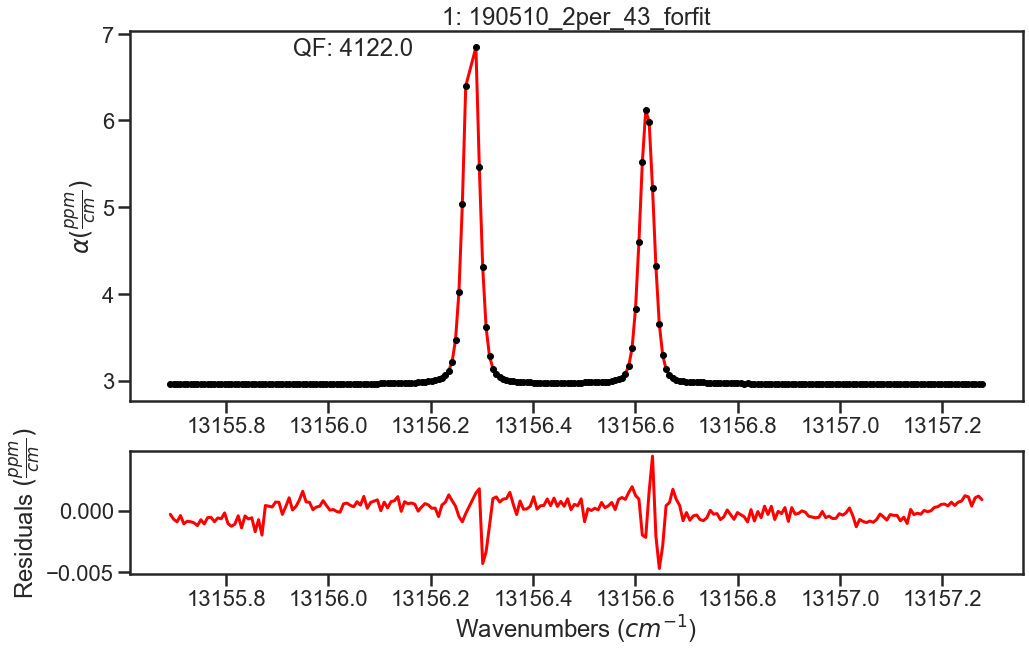

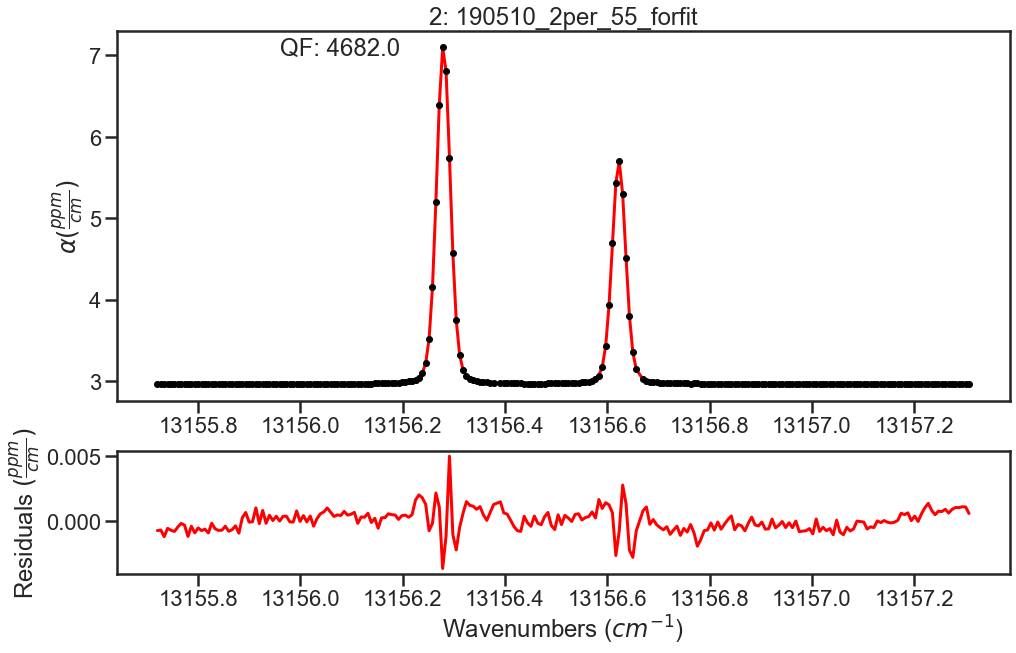

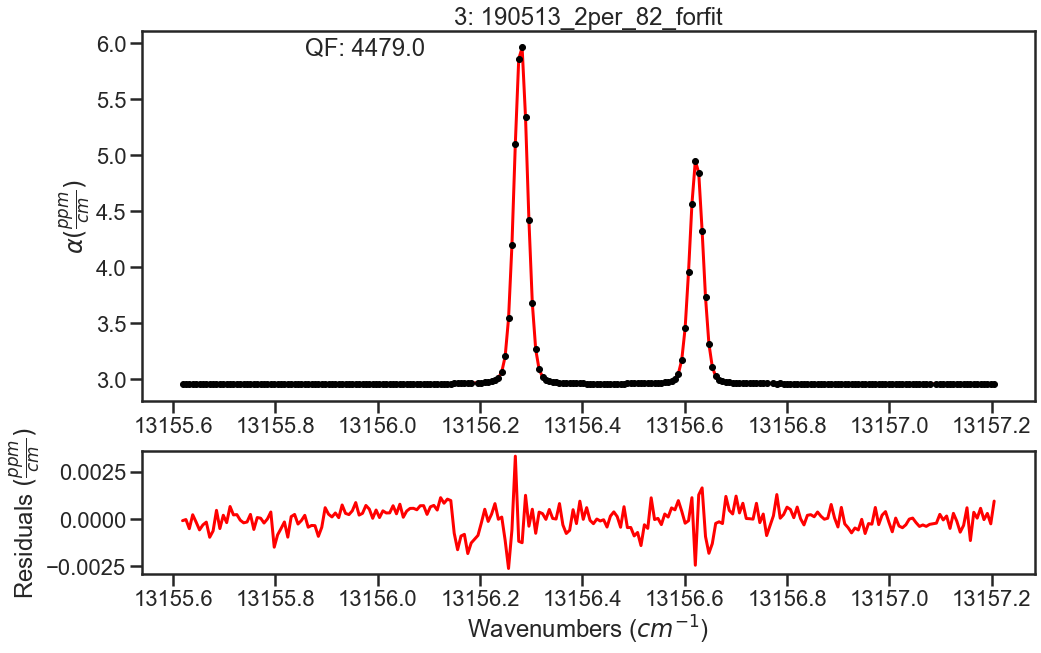

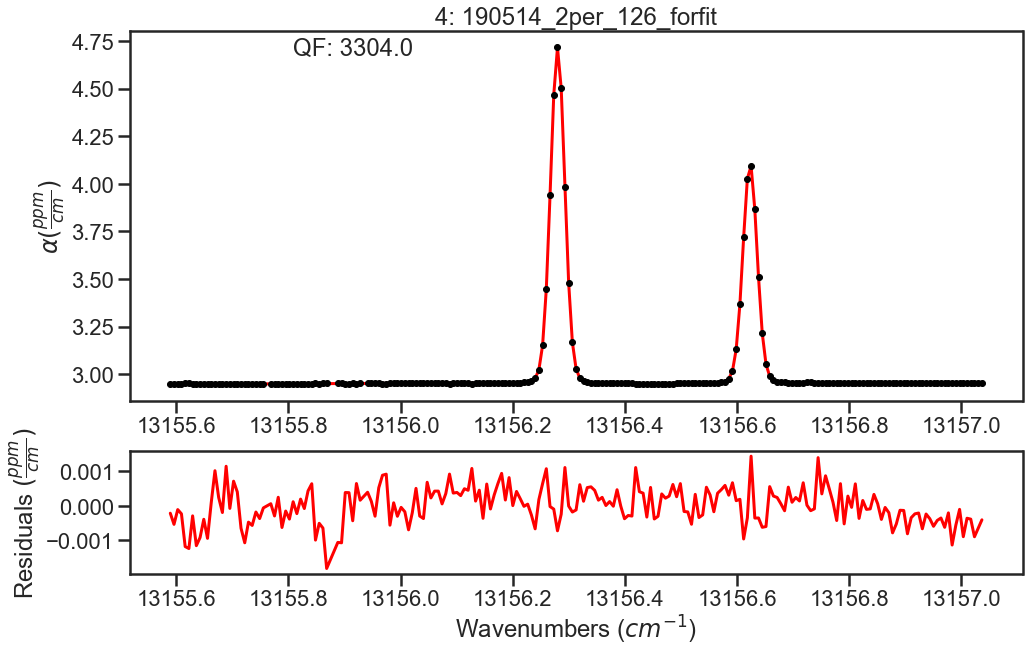

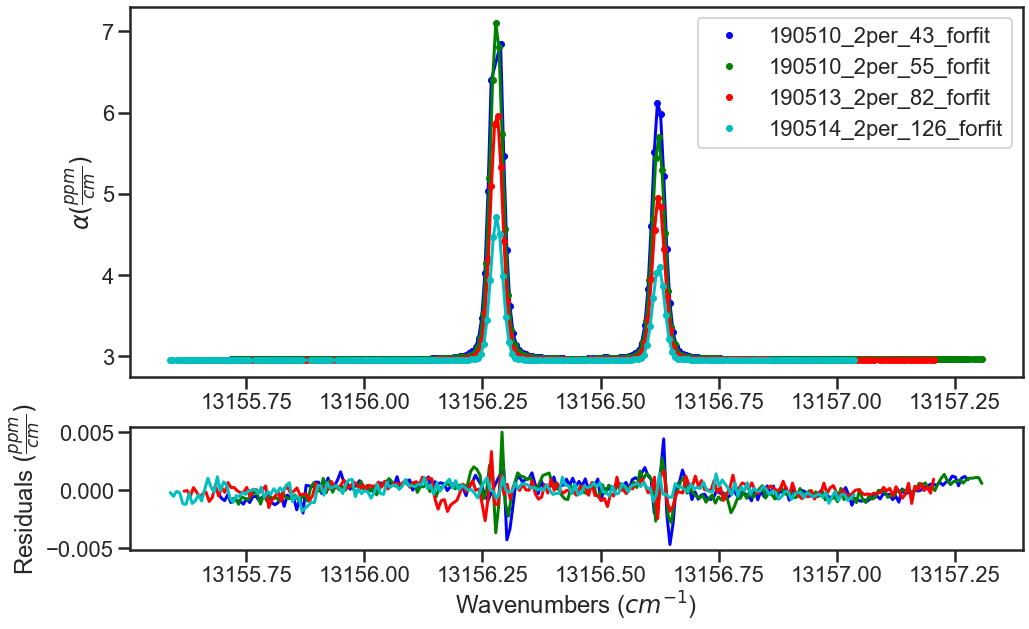

In [7]:
fit_data = MATS.Fit_DataSet(SPECTRA,'Baseline_LineList', 'Parameter_LineList', minimum_parameter_fit_intensity = Fit_Intensity, weight_spectra = False,
                baseline_limit = False, baseline_limit_factor = 10, 
                molefraction_limit = False, molefraction_limit_factor = 1.1, 
                etalon_limit = False, etalon_limit_factor = 2, #phase is constrained to +/- 2pi, 
                x_shift_limit = False, x_shift_limit_magnitude = 0.5, 
                nu_limit = True, nu_limit_magnitude = 0.1, 
                sw_limit = True, sw_limit_factor = 2, 
                gamma0_limit = False, gamma0_limit_factor = 3, n_gamma0_limit= False, n_gamma0_limit_factor = 50, 
                delta0_limit = False, delta0_limit_factor = 2, n_delta0_limit = False, n_delta0_limit_factor = 50, 
                SD_gamma_limit = False, SD_gamma_limit_factor = 2, n_gamma2_limit = False, n_gamma2_limit_factor = 50, 
                SD_delta_limit = False, SD_delta_limit_factor = 50, n_delta2_limit = False, n_delta2_limit_factor = 50, 
                nuVC_limit = False, nuVC_limit_factor = 2, n_nuVC_limit = False, n_nuVC_limit_factor = 50, 
                eta_limit = False, eta_limit_factor = 50, linemixing_limit = False, linemixing_limit_factor = 50)
params = fit_data.generate_params()



for param in params:
    if 'SD_gamma' in param:
        if params[param].vary == True:
            params[param].set(min = 0.01, max = 0.25)
    if 'etalon_1_amp' in param:
        if param != 'etalon_1_amp_1_1':
            params[param].set(expr='etalon_1_amp_1_1')
            
        


result = fit_data.fit_data(params, wing_cutoff = 25)
print (result.params.pretty_print())

fit_data.residual_analysis(result, indv_resid_plot=True)
fit_data.update_params(result)
SPECTRA.generate_summary_file(save_file = True)
SPECTRA.plot_model_residuals()




Call to the MATS.Spectrum.fft_spectrum() function takes an FFT of the residuals. If we hadn’t included the etalon, the result of the fft_spectrum() functions would show a peak with the most abundant period being 1.271443 cm-1 and an amplitude of 0.001364, which were used as the initial guess for the etalon in the spectrum class definitions. The more etalon periods present in the spectral region being fit the more precise the etalon amplitude and frequency determined by the FFT will be.

    Period (cm)  Amplitude     Phase  Freq (cm-1)
0      2.542886   0.000209  0.157726     0.393254
1      1.271443   0.000178 -2.952823     0.786508
2     55.307760   0.000170 -3.085027     0.018081
3      8.264378   0.000160  0.409063     0.121001
4      6.357214   0.000150  0.135966     0.157302
5     14.621592   0.000144 -3.053235     0.068392
6     38.143283   0.000143  2.265729     0.026217
7     10.807263   0.000143  3.127083     0.092530
8     35.600397   0.000142  1.105588     0.028090
9     46.407660   0.000140  0.441721     0.021548
10    33.057512   0.000136 -1.328842     0.030250
11    15.893034   0.000135 -2.566205     0.062921
12    12.078706   0.000134 -0.580583     0.082790
13    63.572138   0.000123  0.242331     0.015730
14    10.171542   0.000122  0.213844     0.098314
15    43.864775   0.000122 -1.375239     0.022797
16    41.321889   0.000122  2.474624     0.024200
17     6.992935   0.000121  2.664595     0.143001
18    47.043382   0.000116 -0.951093     0.021257


C:\Users\ema3\MATS\MATS\spectrum.py:420: RuntimeWarning: divide by zero encountered in true_divide
  FFT['Freq (cm-1)'] = 1 / fft_freq
C:\Users\ema3\MATS\MATS\spectrum.py:425: RuntimeWarning: divide by zero encountered in true_divide
  plt.plot(1 / fft_freq, fft_amplitude, '-')


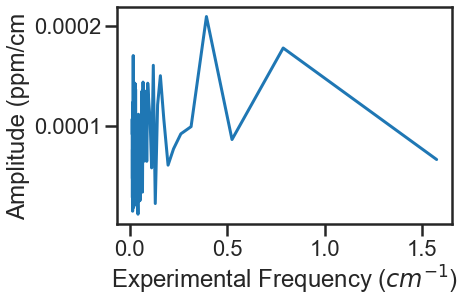

In [8]:
spec_3.fft_spectrum()

## Explore the Ability to Weight spectra

Spectra can be weighted in two different ways, using the stats column defined for each spectrum or weighting the entire spectrum.  In the first example below, we use use the same code that was introduced previously, but set the weight_spectra variable in the Fit_Dataset definitions to True.  This weights the contribution to the solution at each point in each spectrum by 1/tau_stats_column.  If the tau_stats_column is not defined then this will default to the equal weights for all data points.   

Name                     Value      Min      Max   Stderr     Vary     Expr Brute_Step
Pressure_1_1           0.07911     -inf      inf        0    False     None     None
Pressure_2_1           0.06556     -inf      inf        0    False     None     None
Pressure_3_1           0.04602     -inf      inf        0    False     None     None
Pressure_4_1           0.02488     -inf      inf        0    False     None     None
SD_delta_air_line_1          0     -inf      inf        0    False     None     None
SD_delta_air_line_10         0     -inf      inf        0    False     None     None
SD_delta_air_line_13         0     -inf      inf        0    False     None     None
SD_delta_air_line_25         0     -inf      inf        0    False     None     None
SD_delta_air_line_26         0     -inf      inf        0    False     None     None
SD_gamma_air_line_1        0.1     -inf      inf        0    False     None     None
SD_gamma_air_line_10    0.1069     0.01     0.25 0.001312     T

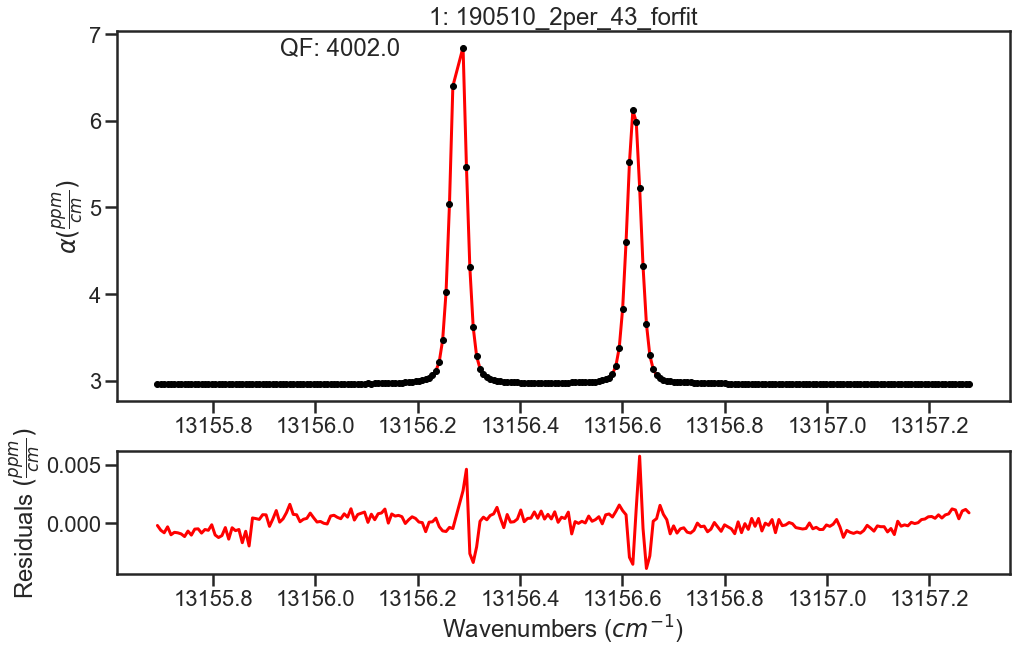

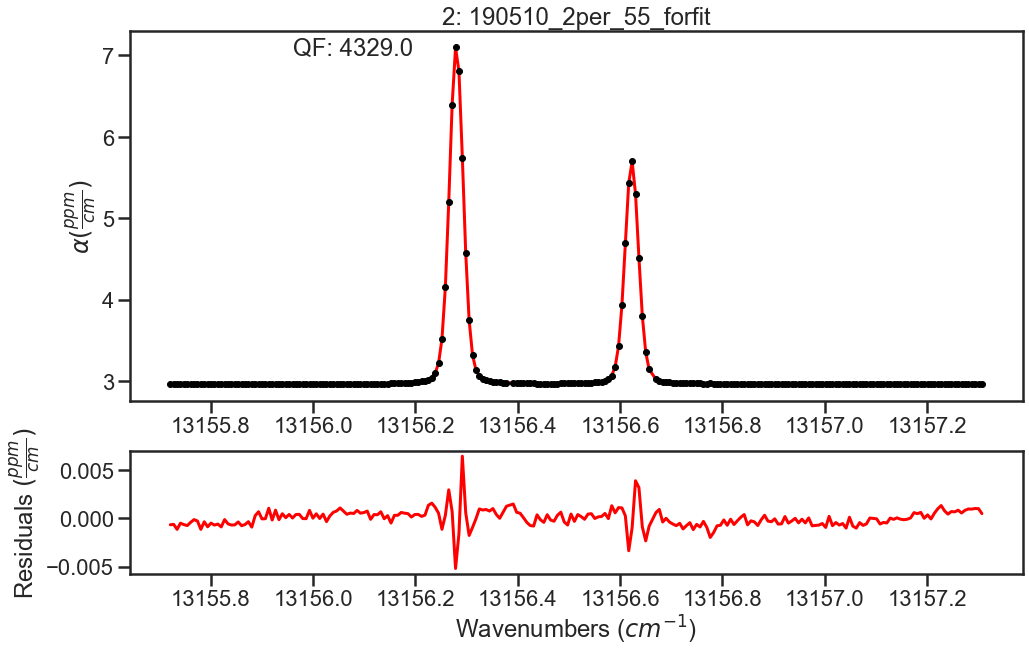

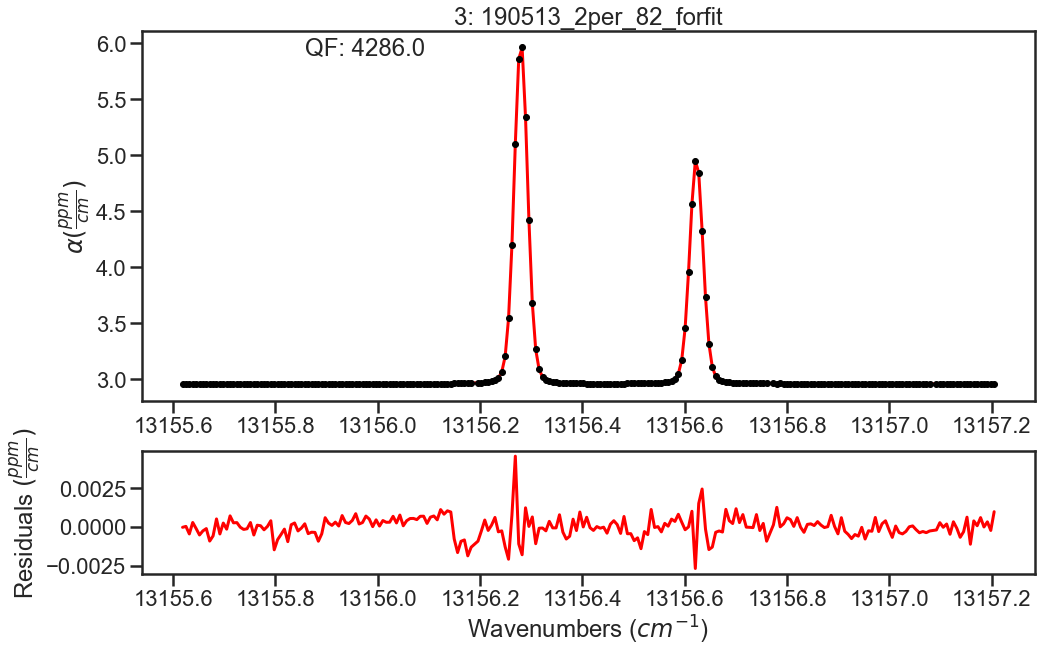

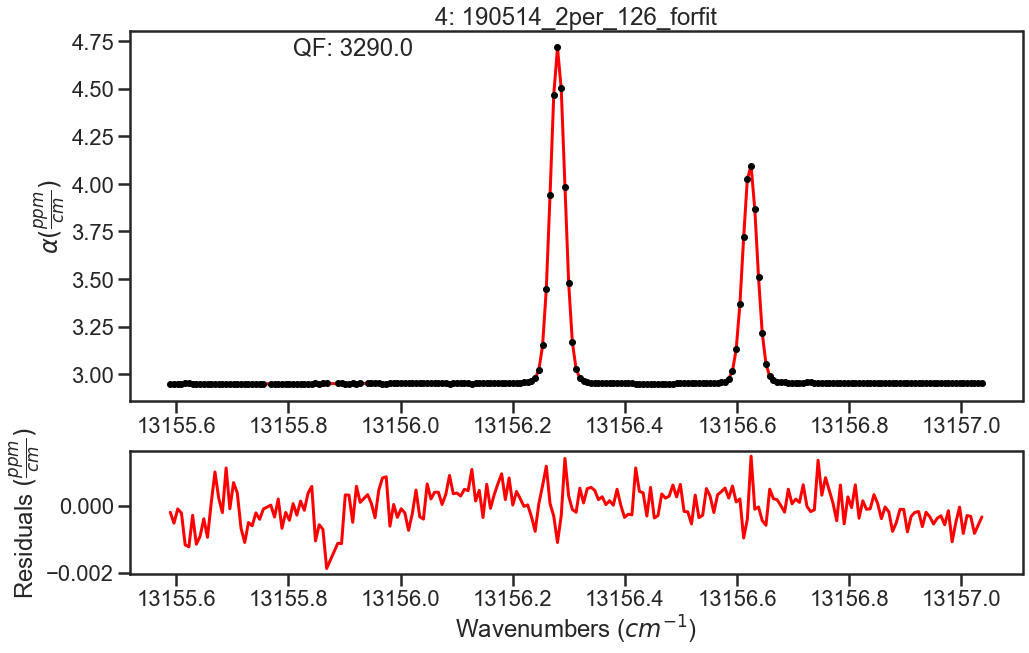

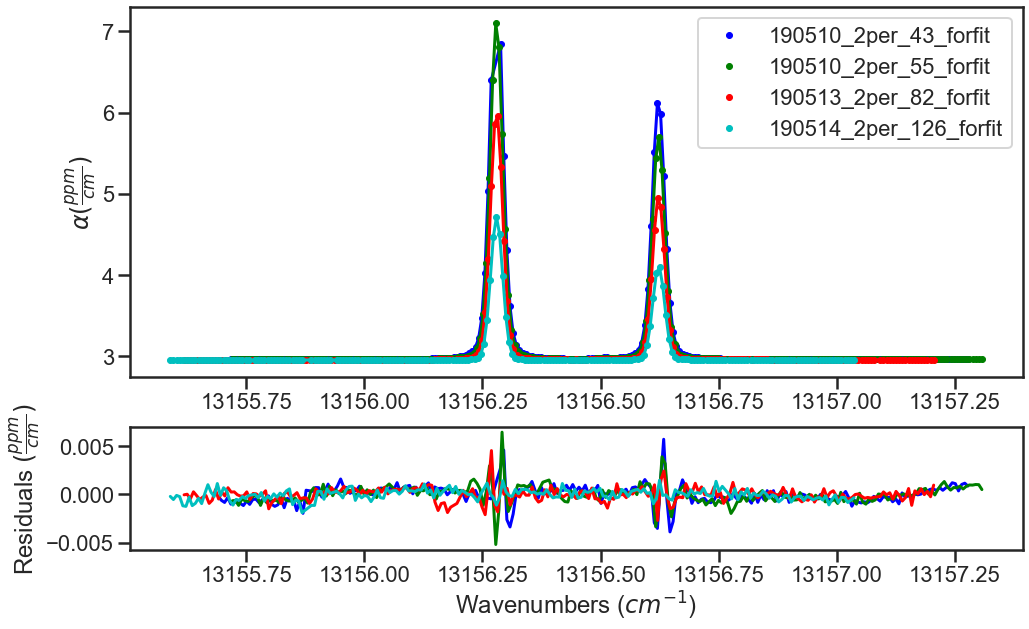

In [9]:
# Set-up for Fitting
  

FITPARAMS = MATS.Generate_FitParam_File(SPECTRA, PARAM_LINELIST, BASE_LINELIST, lineprofile = 'SDVP', linemixing = True, 
                                  fit_intensity = Fit_Intensity, threshold_intensity = IntensityThreshold, sim_window = wave_range,
                                  nu_constrain = False, sw_constrain = False, gamma0_constrain = True, delta0_constrain = True, 
                                   aw_constrain = True, as_constrain = True, 
                                   nuVC_constrain = True, eta_constrain =True, linemixing_constrain = True)
                                  #additional_columns = ['trans_id', 'local_lower_quanta', 'm'])

FITPARAMS.generate_fit_param_linelist_from_linelist(vary_nu = {7:{1:True, 2:False, 3:False}}, vary_sw = {7:{1:True, 2:False, 3:False}},
                                                    vary_gamma0 = {7:{1: True, 2:False, 3: False}, 1:{1:False}}, vary_n_gamma0 = {7:{1:True}}, 
                                                    vary_delta0 = {7:{1: False, 2:False, 3: False}, 1:{1:False}}, vary_n_delta0 = {7:{1:True}}, 
                                                    vary_aw = {7:{1: True, 2:False, 3: False}, 1:{1:False}}, vary_n_gamma2 = {7:{1:False}}, 
                                                    vary_as = {}, vary_n_delta2 = {7:{1:False}}, 
                                                    vary_nuVC = {7:{1:False}}, vary_n_nuVC = {7:{1:False}},
                                                    vary_eta = {}, vary_linemixing = {7:{1:False}})

FITPARAMS.generate_fit_baseline_linelist(vary_baseline = True, vary_molefraction = {7:False, 1:False}, vary_xshift = False, 
                                      vary_etalon_amp= True, vary_etalon_period= False, vary_etalon_phase= True)


fit_data = MATS.Fit_DataSet(SPECTRA,'Baseline_LineList', 'Parameter_LineList', minimum_parameter_fit_intensity = Fit_Intensity, weight_spectra = True,
                baseline_limit = False, baseline_limit_factor = 10, 
                molefraction_limit = False, molefraction_limit_factor = 1.1, 
                etalon_limit = False, etalon_limit_factor = 2, #phase is constrained to +/- 2pi, 
                x_shift_limit = False, x_shift_limit_magnitude = 0.5, 
                nu_limit = True, nu_limit_magnitude = 0.1, 
                sw_limit = True, sw_limit_factor = 2, 
                gamma0_limit = False, gamma0_limit_factor = 3, n_gamma0_limit= False, n_gamma0_limit_factor = 50, 
                delta0_limit = False, delta0_limit_factor = 2, n_delta0_limit = False, n_delta0_limit_factor = 50, 
                SD_gamma_limit = False, SD_gamma_limit_factor = 2, n_gamma2_limit = False, n_gamma2_limit_factor = 50, 
                SD_delta_limit = False, SD_delta_limit_factor = 50, n_delta2_limit = False, n_delta2_limit_factor = 50, 
                nuVC_limit = False, nuVC_limit_factor = 2, n_nuVC_limit = False, n_nuVC_limit_factor = 50, 
                eta_limit = False, eta_limit_factor = 50, linemixing_limit = False, linemixing_limit_factor = 50)
params = fit_data.generate_params()



for param in params:
    if 'SD_gamma' in param:
        if params[param].vary == True:
            params[param].set(min = 0.01, max = 0.25)
    if 'etalon_1_amp' in param:
        if param != 'etalon_1_amp_1_1':
            params[param].set(expr='etalon_1_amp_1_1')
            
        


result = fit_data.fit_data(params, wing_cutoff = 25)
print (result.params.pretty_print())

fit_data.residual_analysis(result, indv_resid_plot=True)
fit_data.update_params(result)
SPECTRA.generate_summary_file(save_file = True)
SPECTRA.plot_model_residuals()


The other option for weighting, that can be used with or without the point by point weighting, is to weight each spectrum by setting the spectrum weight value.  The default for each spectrum is 1.  This value can be set through the weight parameter in the spectrum definition or by using the set_weight(value) command, which is shown below.  

For all weighting options, the residuals are adjusted by the weight factors.  For this example, where the spec_1 is given a weight of 0 this effectively removes spec_1 from the solution consideration.  Note that setting the weight to 0 will return a warning message.



Change the weight to a non-zero value or remove the spectrum from the dataset.  If the weight is 0, then the residuals returned for that spectrum will be 0. 
Name                     Value      Min      Max   Stderr     Vary     Expr Brute_Step
Pressure_1_1           0.07911     -inf      inf     None    False     None     None
Pressure_2_1           0.06556     -inf      inf     None    False     None     None
Pressure_3_1           0.04602     -inf      inf     None    False     None     None
Pressure_4_1           0.02488     -inf      inf     None    False     None     None
SD_delta_air_line_1          0     -inf      inf     None    False     None     None
SD_delta_air_line_10         0     -inf      inf     None    False     None     None
SD_delta_air_line_13         0     -inf      inf     None    False     None     None
SD_delta_air_line_25         0     -inf      inf     None    False     None     None
SD_delta_air_line_26         0     -inf      inf     None    False     None

C:\Users\ema3\MATS\MATS\spectrum.py:343: RuntimeWarning: divide by zero encountered in double_scalars
  return np.around((self.alpha.max() - self.alpha.min()) / self.residuals.std(),0)


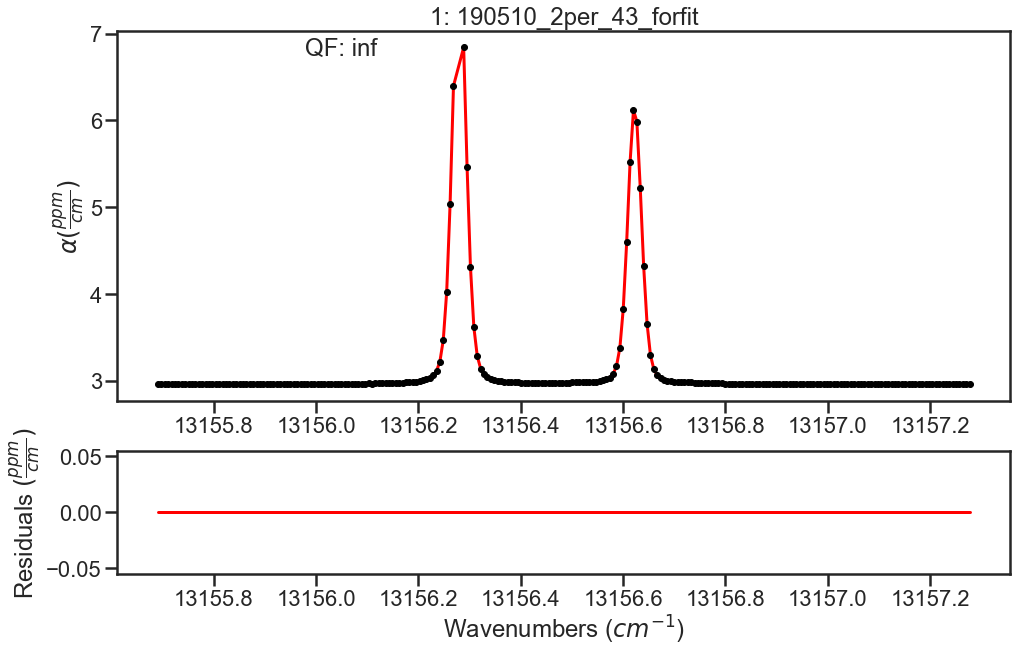

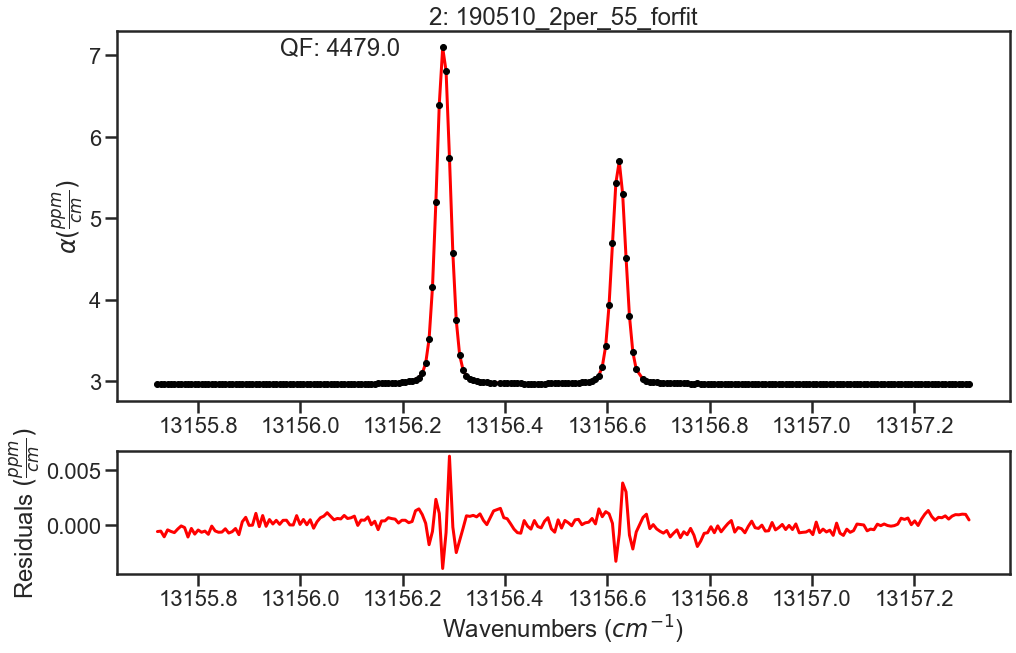

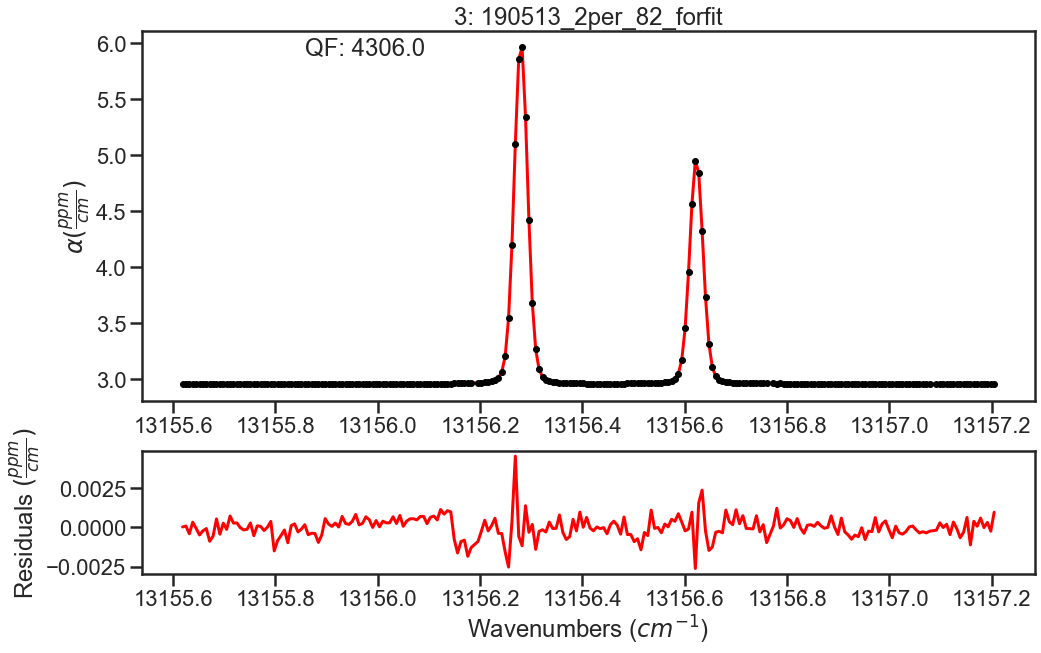

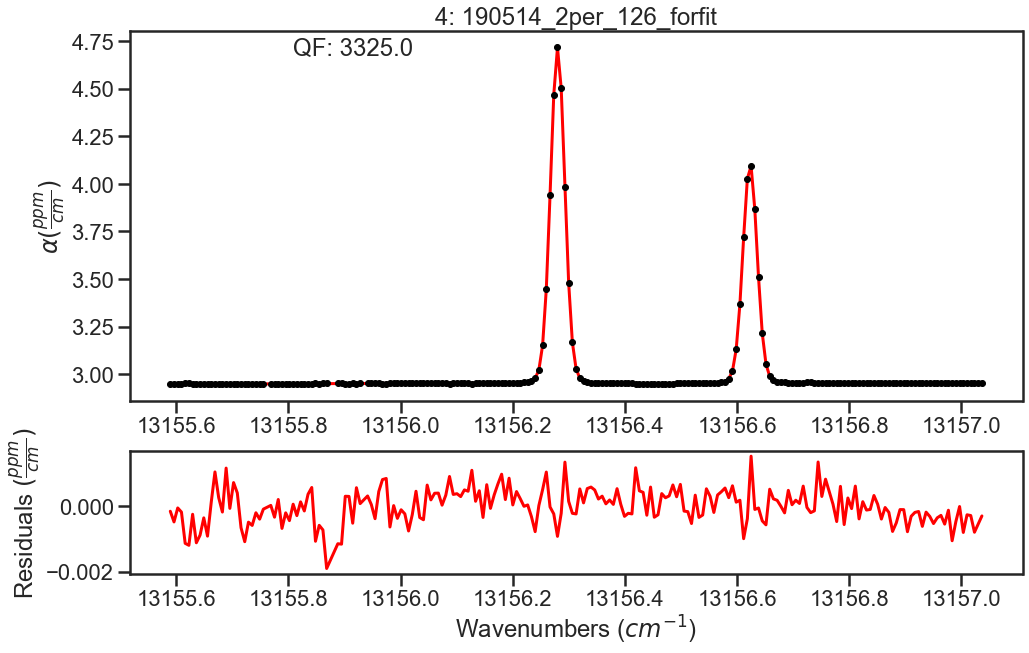

C:\Users\ema3\MATS\MATS\spectrum.py:343: RuntimeWarning: divide by zero encountered in double_scalars
  return np.around((self.alpha.max() - self.alpha.min()) / self.residuals.std(),0)


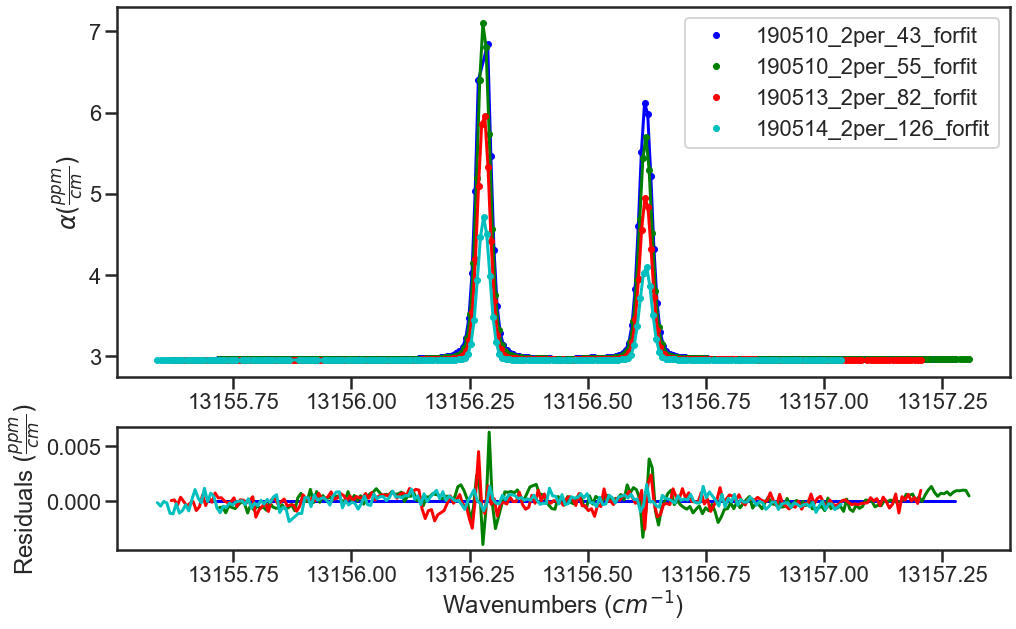

In [10]:
# Change the Weights of spectra and use stats column
spec_1.set_weight(0)
FITPARAMS = MATS.Generate_FitParam_File(SPECTRA, PARAM_LINELIST, BASE_LINELIST, lineprofile = 'SDVP', linemixing = False, 
                                  fit_intensity = Fit_Intensity, threshold_intensity = IntensityThreshold, sim_window = wave_range,
                                  nu_constrain = False, sw_constrain = False, gamma0_constrain = True, delta0_constrain = True, 
                                   aw_constrain = True, as_constrain = True, 
                                   nuVC_constrain = True, eta_constrain =True, linemixing_constrain = True)
                                  #additional_columns = ['trans_id', 'local_lower_quanta', 'm'])

FITPARAMS.generate_fit_param_linelist_from_linelist(vary_nu = {7:{1:True, 2:False, 3:False}}, vary_sw = {7:{1:True, 2:False, 3:False}},
                                                    vary_gamma0 = {7:{1: True, 2:False, 3: False}, 1:{1:False}}, vary_n_gamma0 = {7:{1:True}}, 
                                                    vary_delta0 = {7:{1: False, 2:False, 3: False}, 1:{1:False}}, vary_n_delta0 = {7:{1:True}}, 
                                                    vary_aw = {7:{1: True, 2:False, 3: False}, 1:{1:False}}, vary_n_gamma2 = {7:{1:False}}, 
                                                    vary_as = {}, vary_n_delta2 = {7:{1:False}}, 
                                                    vary_nuVC = {7:{1:False}}, vary_n_nuVC = {7:{1:False}},
                                                    vary_eta = {}, vary_linemixing = {7:{1:False}})

FITPARAMS.generate_fit_baseline_linelist(vary_baseline = True, vary_molefraction = {7:False, 1:False}, vary_xshift = False, 
                                      vary_etalon_amp= True, vary_etalon_period= False, vary_etalon_phase= True)


fit_data = MATS.Fit_DataSet(SPECTRA,'Baseline_LineList', 'Parameter_LineList', minimum_parameter_fit_intensity = Fit_Intensity, weight_spectra = True,
                baseline_limit = False, baseline_limit_factor = 10, 
                molefraction_limit = False, molefraction_limit_factor = 1.1, 
                etalon_limit = False, etalon_limit_factor = 2, #phase is constrained to +/- 2pi, 
                x_shift_limit = False, x_shift_limit_magnitude = 0.5, 
                nu_limit = True, nu_limit_magnitude = 0.1, 
                sw_limit = True, sw_limit_factor = 2, 
                gamma0_limit = False, gamma0_limit_factor = 3, n_gamma0_limit= False, n_gamma0_limit_factor = 50, 
                delta0_limit = False, delta0_limit_factor = 2, n_delta0_limit = False, n_delta0_limit_factor = 50, 
                SD_gamma_limit = False, SD_gamma_limit_factor = 2, n_gamma2_limit = False, n_gamma2_limit_factor = 50, 
                SD_delta_limit = False, SD_delta_limit_factor = 50, n_delta2_limit = False, n_delta2_limit_factor = 50, 
                nuVC_limit = False, nuVC_limit_factor = 2, n_nuVC_limit = False, n_nuVC_limit_factor = 50, 
                eta_limit = False, eta_limit_factor = 50, linemixing_limit = False, linemixing_limit_factor = 50)
params = fit_data.generate_params()



for param in params:
    if 'SD_gamma' in param:
        if params[param].vary == True:
            params[param].set(min = 0.01, max = 0.25)
    if 'etalon_1_amp' in param:
        if param != 'etalon_1_amp_1_1':
            params[param].set(expr='etalon_1_amp_1_1')
            
        


result = fit_data.fit_data(params, wing_cutoff = 25)
print (result.params.pretty_print())

fit_data.residual_analysis(result, indv_resid_plot=True)
fit_data.update_params(result)
SPECTRA.generate_summary_file(save_file = True)
SPECTRA.plot_model_residuals()
